# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from substitutors import *
from filters import *

# Logger level
logger.setLevel(logging.INFO)

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
mouseline = DEFAULT_LINE # Mouse line
layer = DEFAULT_LAYER  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
baseline_wlen = BASELINE_WLEN  # length of rolling window for baseline computation
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile in folling window for baseline evaluation
baseline_smoothing = BASELINE_SMOOTHING   # whether to smooth the baseline with an extra moving average
ykey_postpro = Label.DFF  # variable of interest for post-processing

### Derived parameters

In [4]:
dataroot = get_data_root()
figsdir = get_output_equivalent(dataroot, 'raw', 'figs')
trialavg_root = get_output_equivalent(dataroot, 'raw', 'trial-averaged')
# Construct dataset group ID
dataset_group_id = mouseline
if layer is not None:
    dataset_group_id = f'{dataset_group_id}_{layer}'
# Construct post-processing ID
if baseline_wlen is None:
    baseline_smoothing = False
    baseline_id = ''
else:
    baseline_id = f'w{baseline_wlen:.1f}s'
baseline_id = f'{baseline_id}_q{baseline_quantile:.2f}'
if baseline_smoothing:
    baseline_id = f'{baseline_id}_smooth'
postpro_id = f'{baseline_id}_{ykey_postpro}'.replace('/', '')
figs_suffix = f'{dataset_group_id}_k{kalman_gain}_{postpro_id}'
submap = [(1, 0), (FrameIndex.STIM - 1, FrameIndex.STIM)]
ss = StackSubstitutor(submap, repeat_every=NFRAMES_PER_TRIAL)
kd = KalmanDenoiser(kalman_gain) if kalman_gain > 0 else NoFilter
trialavg_dir = os.path.join(trialavg_root, baseline_id, kd.code, ss.code, mouseline)

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} batch notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 07/06/2022 11:04:27: line3_layer2-3 batch notebook started on 2022-06-07 at 11:04:27


### Input summary table figure

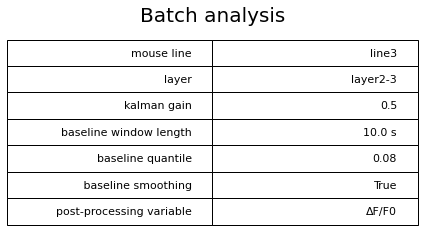

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'kalman gain': kalman_gain,
    'baseline window length': f'{baseline_wlen:.1f} s',
    'baseline quantile': baseline_quantile,
    ' baseline smoothing': baseline_smoothing,
    'post-processing variable': ykey_postpro
    }, title='Batch analysis')

## Input data

### Load data

In [25]:
logger.info(f'loading data from {trialavg_dir}:')
data = load_trialavg_datasets(trialavg_dir, exclude_patterns=['2021'])

 07/06/2022 11:26:22: loading data from /Users/tlemaire/Documents/data/usnm/trial-averaged/w10.0s_q0.08_smooth/kd_G0.5_V0.05_npad10/submap0<-1_9->10_every100/line3:
 07/06/2022 11:26:22: excluding datasets with the following patterns: ['2021']
 07/06/2022 11:26:22: loading trial-averaged data from 20191112_mouse12_region1.h5
 07/06/2022 11:26:22: gathering dataset IDs...
 07/06/2022 11:26:22: sorting dataset indexes...
 07/06/2022 11:26:23: checking for run order consistency across datasets...
 07/06/2022 11:26:23: adding post-stim avg Z(ΔF/F0) - pre-stim avg Z(ΔF/F0) metrics to stats dataset...
 07/06/2022 11:26:23: applying series_avg function on Z(ΔF/F0) in [5-10] index window across dataset, ROI, run ...
 07/06/2022 11:26:23: applying series_avg function on Z(ΔF/F0) in [10-19] index window across dataset, ROI, run ...


### Breakdown per mouse region & filter out datasets

 07/06/2022 11:26:28: extracting timeseries and stats from data...
 07/06/2022 11:26:28: setting minimum cell count of 252 as inclusion criterion
 07/06/2022 11:26:28: ['20191110_mouse6_region1_layer5', '20191112_mouse12_region2_layer5', '20191108_mouse6_region1', '20191109_mouse7_region2', '20191109_mouse7_region3_layer5'] datasets not found -> ignoring
 07/06/2022 11:26:28: did not find any datasets to exclude


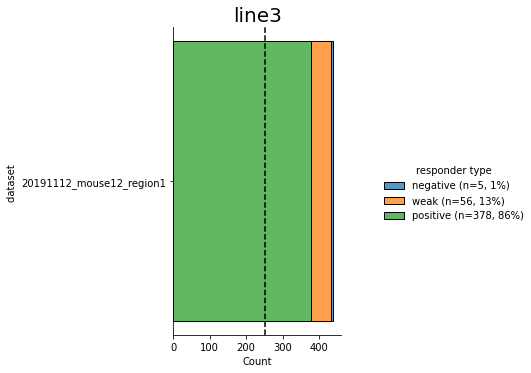

In [26]:
logger.info('extracting timeseries and stats from data...')
timeseries, stats = data['timeseries'], data['stats']

# Compute cell count threshold
um_per_px = 1.96  # from Bruker microscope
npx_per_line = 256  # from Bruker miscroscope
area = (um_per_px * npx_per_line)**2 / 1e6  # mm2
min_cell_count = int(np.round(MIN_CELL_DENSITY * area))

# Plot breakdown
figs['rtype dist per mousereg'] = plot_cellcounts_by_type(
    stats, hue=Label.ROI_RESP_TYPE, countref=min_cell_count,
    title=mouseline)

# Idendify datasets with a low overall cell count
logger.info(f'setting minimum cell count of {min_cell_count} as inclusion criterion')
cells = stats.groupby([Label.DATASET, Label.ROI]).first()
cellcounts = cells.groupby(Label.DATASET).count().iloc[:, 0].rename('cell count')
weaks = cells.loc[cells[Label.ROI_RESP_TYPE] == 'weak']
weakcounts = weaks.groupby(Label.DATASET).count().iloc[:, 0].rename('weak count')
pctresp = (1 - (weakcounts / cellcounts)) * 100
count_exclude = cellcounts.loc[cellcounts < min_cell_count].index.values.tolist()

# Manual exclusions
manual_exclude = [
    '20191108_mouse6_region1',
    '20191109_mouse7_region2',
    '20191110_mouse6_region1_layer5',
    '20191109_mouse7_region3_layer5',
    '20191112_mouse12_region2_layer5',
]

# Exclude them
timeseries, stats = exclude_datasets(timeseries, stats, count_exclude + manual_exclude)

## Parameter dependency curves

### Plotting function

In [46]:
def plot_dep_curves(stats, ykey, title=None):
    logger.setLevel(logging.WARNING)
    for pkey in [Label.P, Label.DC]:
        figs[f'{pkey}-dep {ykey}'] = plot_parameter_dependency_across_datasets(
            stats, pkey, ykey, weighted=True, ybounds=None)
        if title is not None:
            figs[f'{pkey}-dep {ykey}'].suptitle(title)
    logger.setLevel(logging.INFO)

### With default parameters

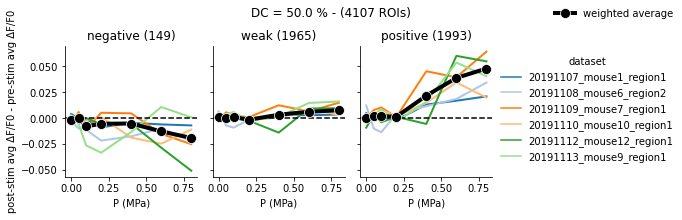

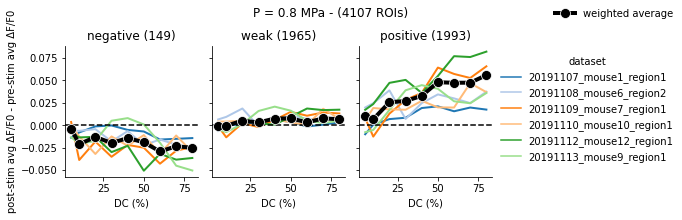

In [47]:
plot_dep_curves(stats, ykey_postpro)

### Influence of threshold number of conditions 

 06/06/2022 19:35:28: re-classifying responders with threshold number of conditions = 3
 06/06/2022 19:35:29: cell breakdown:
  - positive: 3001 (73.1%)
  - weak: 784 (19.1%)
  - negative: 322 (7.8%)
 06/06/2022 19:35:29: re-classifying responders with threshold number of conditions = 5
 06/06/2022 19:35:30: cell breakdown:
  - positive: 1993 (48.5%)
  - weak: 1965 (47.8%)
  - negative: 149 (3.6%)
 06/06/2022 19:35:31: re-classifying responders with threshold number of conditions = 7
 06/06/2022 19:35:31: cell breakdown:
  - weak: 2869 (69.9%)
  - positive: 1195 (29.1%)
  - negative: 43 (1.0%)


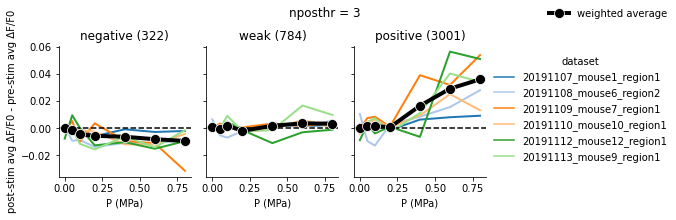

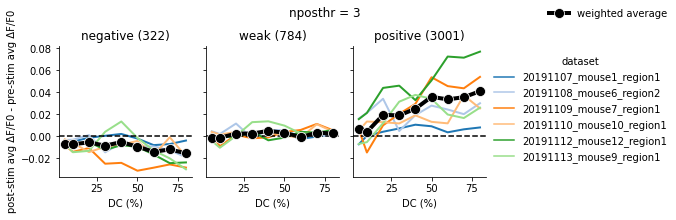

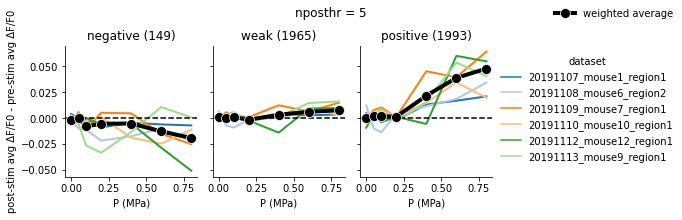

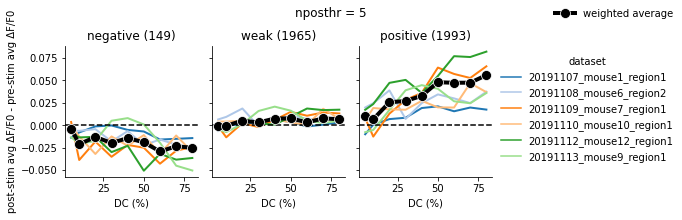

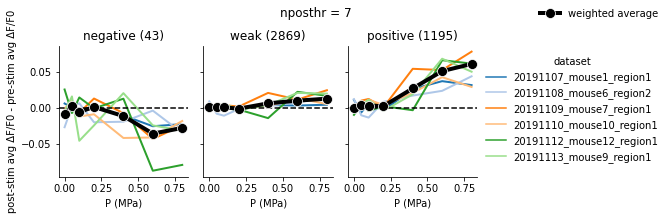

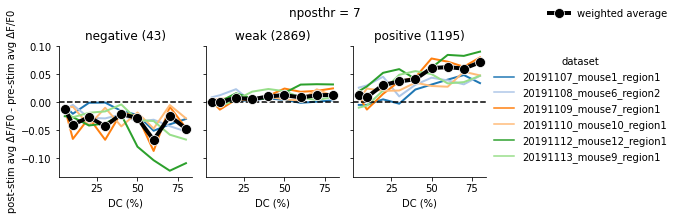

In [48]:
for n in [3, 5, 7]:
    stats2 = classify_responders(stats.copy(), nposthr=n)
    plot_dep_curves(stats2, ykey_postpro, title=f'nposthr = {n}')

### Influence of pre-stimulus anbd post-stimulus detection windows

 06/06/2022 19:39:40: adding post-stim avg ΔF/F0 - pre-stim avg ΔF/F0 metrics to stats dataset...
 06/06/2022 19:39:40: applying series_avg function on ΔF/F0 in [8-10] index window across dataset, ROI, run ...
 06/06/2022 19:39:44: applying series_avg function on ΔF/F0 in [10-20] index window across dataset, ROI, run ...
 06/06/2022 19:39:48: testing for significant ΔF/F0 differences between pre- and post-stimulus windows...
 06/06/2022 19:40:30: classifying responses...
 06/06/2022 19:40:30: re-classifying responders with threshold number of conditions = 5
 06/06/2022 19:40:30: cell breakdown:
  - weak: 2277 (55.4%)
  - positive: 1737 (42.3%)
  - negative: 93 (2.3%)
 06/06/2022 19:40:31: adding post-stim avg ΔF/F0 - pre-stim avg ΔF/F0 metrics to stats dataset...
 06/06/2022 19:40:31: applying series_avg function on ΔF/F0 in [8-10] index window across dataset, ROI, run ...
 06/06/2022 19:40:35: applying series_avg function on ΔF/F0 in [10-30] index window across dataset, ROI, run ...
 

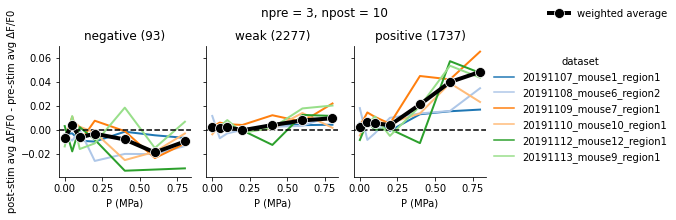

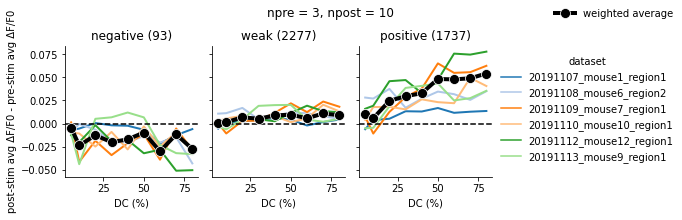

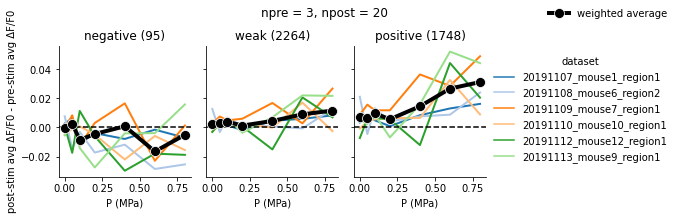

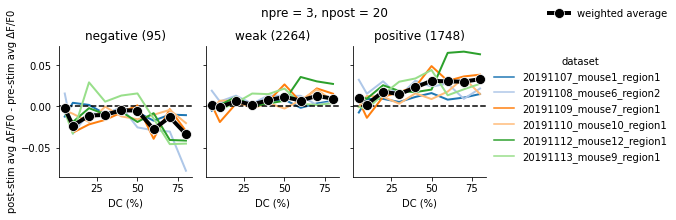

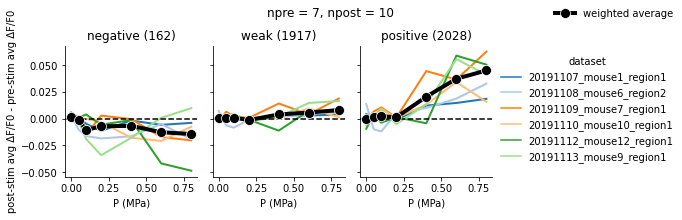

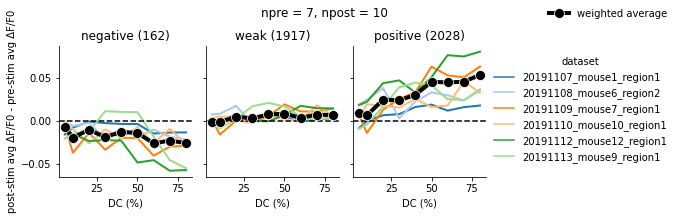

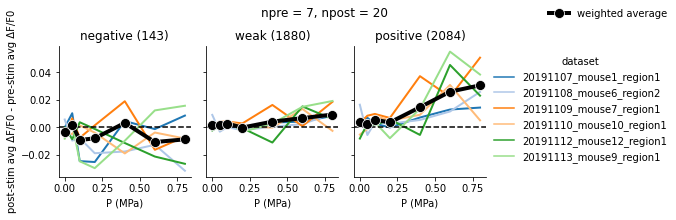

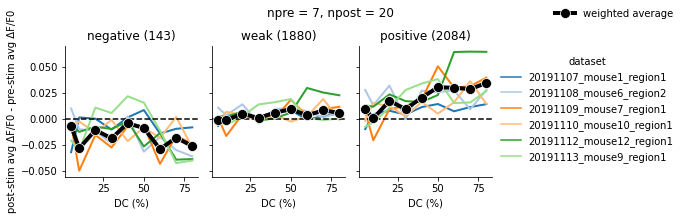

In [50]:
stats_vs_windows = {}
for npre in [3, 7]:
    for npost in [10, 20]:
        stats_vs_windows[f'{npre}_{npost}'] = classify(
            timeseries, stats.copy(), ykey_postpro, 
            wpre=slice(FrameIndex.STIM - npre + 1, FrameIndex.STIM + 1),
            wpost=slice(FrameIndex.STIM, FrameIndex.STIM + npost + 1))
        plot_dep_curves(
            stats_vs_windows[f'{npre}_{npost}'], ykey_postpro,
            title=f'npre = {npre}, npost = {npost}')

## Response traces

### Get plot-ready traces dataset

In [18]:
plt_data = get_plot_data(timeseries, stats)

 02/06/2022 14:51:52: merging timeseries and stats information...
 02/06/2022 14:52:36: adding time info to table...


### Pressure-dependent response traces

 02/06/2022 14:52:48: plotting P (MPa) dependency curves for negative responders...
 02/06/2022 14:52:48: sub-indexing data...
 02/06/2022 14:52:48: filtering data...
 02/06/2022 14:52:48: cross-checking filters...
 02/06/2022 14:52:48: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 02/06/2022 14:52:52: plotting P (MPa) dependency curves for positive responders...
 02/06/2022 14:52:53: sub-indexing data...
 02/06/2022 14:52:53: filtering data...
 02/06/2022 14:52:54: cross-checking filters...
 02/06/2022 14:52:55: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 02/06/2022 14:53:11: plotting P (MPa) dependency curves for weak responders...
 02/06/2022 14:53:13: sub-indexing data...
 02/06/2022 14:53:13: filtering data...
 02/06/2022 14:53:14: cross-checking filters...
 02/06/2022 14:53:15: grouping by dataset, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


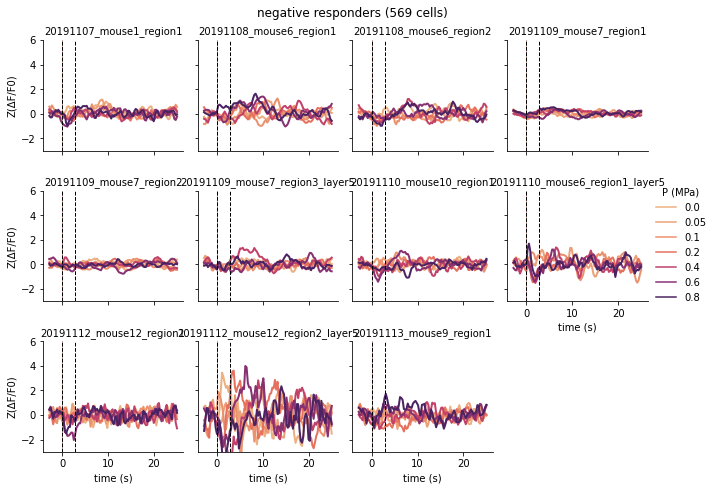

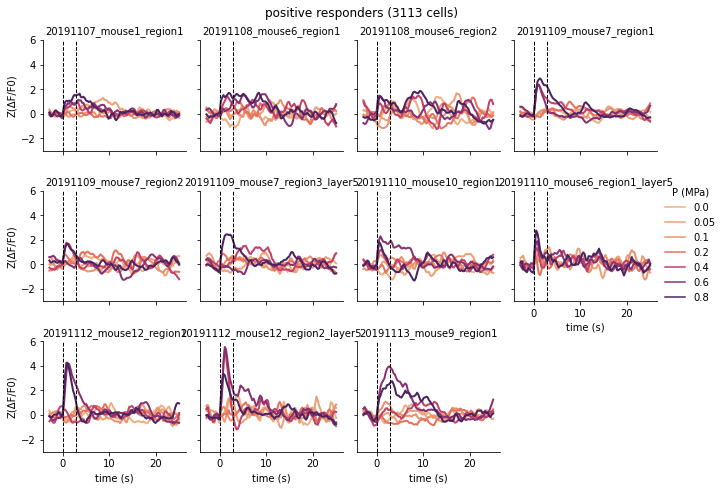

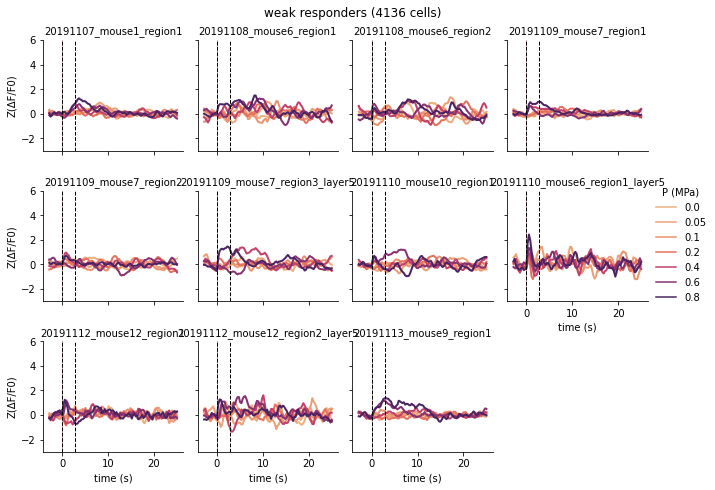

In [19]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.P))

### DC-dependent response traces

 02/06/2022 14:53:44: plotting DC (%) dependency curves for negative responders...
 02/06/2022 14:53:44: sub-indexing data...
 02/06/2022 14:53:44: filtering data...
 02/06/2022 14:53:44: cross-checking filters...
 02/06/2022 14:53:45: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 02/06/2022 14:53:49: plotting DC (%) dependency curves for positive responders...
 02/06/2022 14:53:51: sub-indexing data...
 02/06/2022 14:53:51: filtering data...
 02/06/2022 14:53:52: cross-checking filters...
 02/06/2022 14:53:53: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 02/06/2022 14:54:12: plotting DC (%) dependency curves for weak responders...
 02/06/2022 14:54:14: sub-indexing data...
 02/06/2022 14:54:14: filtering data...
 02/06/2022 14:54:16: cross-checking filters...
 02/06/2022 14:54:17: grouping by dataset, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


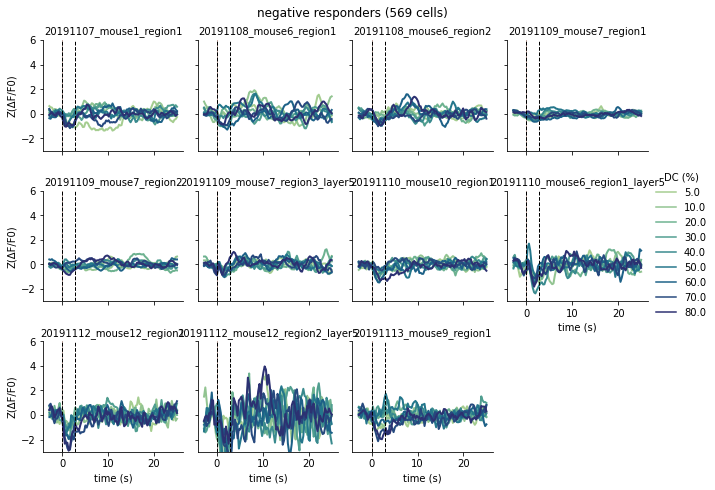

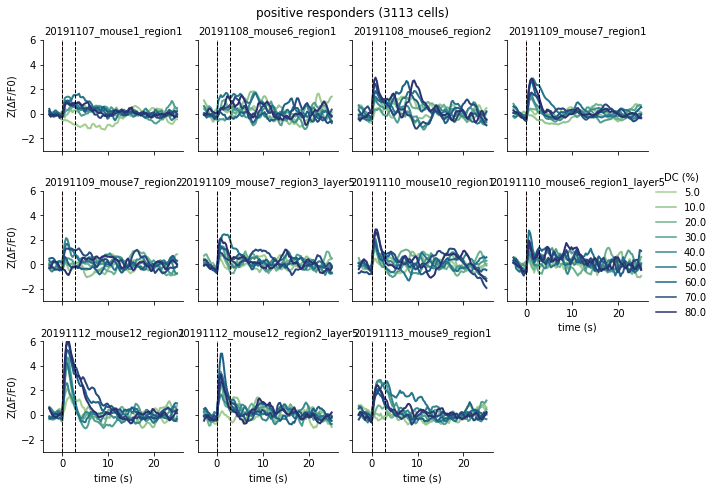

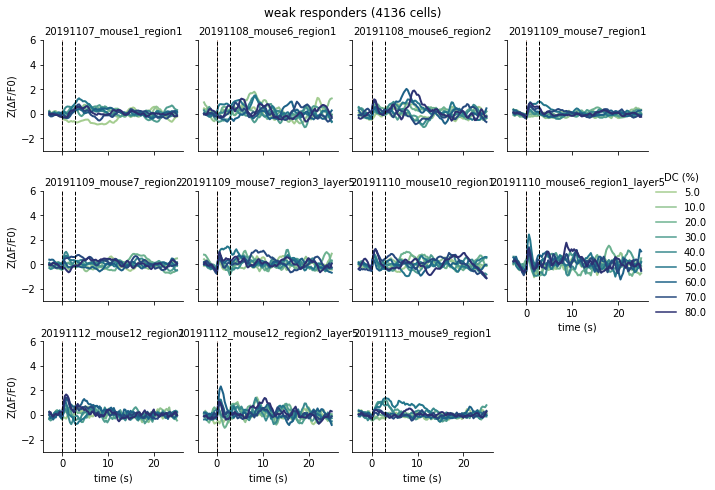

In [20]:
figs.update(
    plot_responses_across_datasets(plt_data, ykey=ykey_postpro, pkey=Label.DC))

### Average response traces across datasets (weighted)

 02/06/2022 14:54:43: sub-indexing data...
 02/06/2022 14:54:43: filtering data...
 02/06/2022 14:54:46: cross-checking filters...
 02/06/2022 14:54:49: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 02/06/2022 14:55:14: sub-indexing data...
 02/06/2022 14:55:14: filtering data...
 02/06/2022 14:55:17: cross-checking filters...
 02/06/2022 14:55:21: grouping by responder type, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


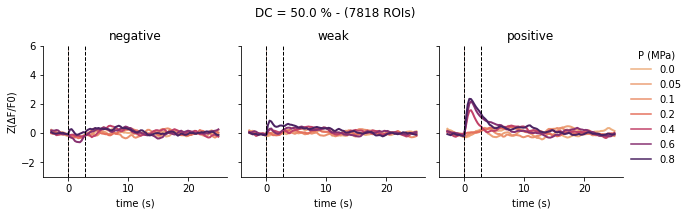

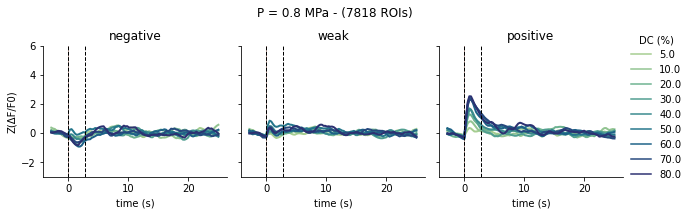

In [21]:
# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - weighted'] = plot_responses_across_datasets(
        plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Average response traces across datasets (non-weighted)

 02/06/2022 14:55:55: checking for run order consistency across datasets...
 02/06/2022 14:55:59: computing average traces per dataset and condition...
 02/06/2022 14:56:03: sub-indexing data...
 02/06/2022 14:56:03: filtering data...
 02/06/2022 14:56:03: cross-checking filters...
 02/06/2022 14:56:03: grouping by responder type, grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 02/06/2022 14:56:03: sub-indexing data...
 02/06/2022 14:56:03: filtering data...
 02/06/2022 14:56:03: cross-checking filters...
 02/06/2022 14:56:03: grouping by responder type, grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


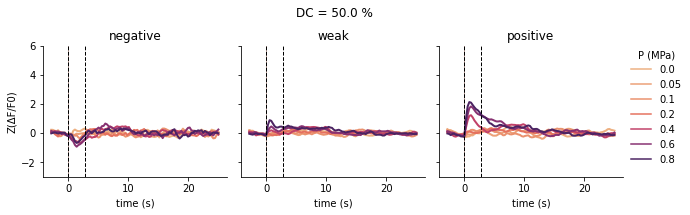

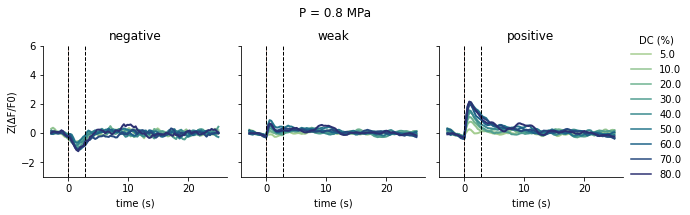

In [22]:
# Check run order consistency across datasets
logger.info('checking for run order consistency across datasets...')
params_per_run = plt_data.groupby([Label.DATASET, Label.RUN]).first()[[Label.P, Label.DC]]
for k in params_per_run:
    sum_of_stds = params_per_run[k].unstack().std().sum()
    if sum_of_stds > 1e-12:
        logger.error('variation in run orders across dataset')

# Group data by mouse-region, response type, run and frame -> average
logger.info('computing average traces per dataset and condition...')
avg_plt_data = plt_data.groupby(
    [Label.DATASET, Label.ROI_RESP_TYPE, Label.RUN, Label.FRAME]).mean()
avg_plt_data = resolve_columns(avg_plt_data, [Label.P, Label.DC, Label.DUR, Label.TIME])

# Plot response curves for both input stimulation parameters  
for pkey in [Label.P, Label.DC]:
    figs[f'{ykey_postpro} vs. {pkey} by type - nonweighted'] = plot_responses_across_datasets(
        avg_plt_data, ykey=ykey_postpro, pkey=pkey, avg=True)

### Save figures

In [23]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 02/06/2022 14:56:04: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2022.06.02/figs_line3_k0.5_w10.0s_q0.08_smooth_Z(ΔFF0).pdf:


100%|██████████| 14/14 [00:03<00:00,  4.35it/s]


### Notify upon completion

In [24]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 02/06/2022 14:56:08: line3 batch notebook completed in 0:23:26.102765 s
